In [3]:
%load_ext autoreload
%autoreload 2

from script.Layer import *
from script.Propagation import *
from script.Optimization import *
from script.Network import *
from util.plots import *

import random
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
%matplotlib inline
random.seed(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<br/>
# Generate some dataset

## Read in data

### Option 1: Simple dataset

In [2]:
X, y = make_moons(1000, noise = 0.1)
print(X.shape, y.shape)

(1000, 2) (1000,)


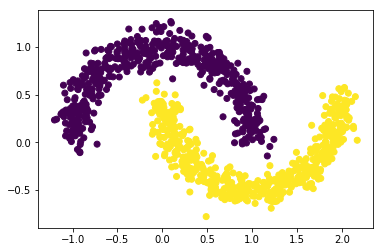

In [3]:
plt.scatter(X[:,0], X[:,1], c = y)

### Option 2: MNIST

In [14]:
# Only using the dataset, not using any function
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
X = mnist.train.images[:3000].astype(np.float64)
y = np.array([ np.where(r==1)[0][0] for r in mnist.train.labels[:3000]], np.int32)
print(X.shape, y.shape)

(3000, 784) (3000,)


### Option 3: IRIS

In [6]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('./IRIS_data/iris_training.csv')
df2 = pd.read_csv('./IRIS_data/iris_test.csv')
df = pd.concat([df1,df2])
df = pd.concat([df,df, df])

In [7]:
X = np.array(df.iloc[:,:4])
X.shape

(450, 4)

In [8]:
y = np.array(df.iloc[:,-1])
y.shape

(450,)

### Option 3: MNIST(3d)

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X = mnist.train.images[:3000].astype(np.float64)
y = np.array([ np.where(r==1)[0][0] for r in mnist.train.labels[:3000]], np.int32)
X = X.reshape(X.shape[0], 1, 28, 28)
print(X.shape, y.shape)
plt.imshow(X[100].reshape(28,28))

## Split training, validation, test set

In [6]:
def train_test_split(X, y, test_size = 0.2, random_state = 42):
    import random
    num_examples = X.shape[0]
    inds = list(range(num_examples))
    test_ind  = random.sample(inds, int(test_size * num_examples))
    train_ind = [ind for ind in inds if ind not in test_ind]
    return X[train_ind,:], y[train_ind], X[test_ind,:], y[test_ind]

In [7]:
X_train_val, y_train_val, X_test, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, y_train, X_val, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1680, 1, 28, 28) (1680,) (720, 1, 28, 28) (720,) (600, 1, 28, 28) (600,)


# Design Network

### Option 1: Simple Example

In [ ]:
network = Network()
layers = []
layers.append(Layer(activation_function = Tanh(), num_neurons = 5))
layers.append(Layer(activation_function = Tanh(), num_neurons = 5))
layers.append(Layer(activation_function = Softmax(), num_neurons = 2))
for layer in layers:
    network.add(layer)

### Option 2: MNIST

In [ ]:
network = Network()
layers = []
layers.append(Layer(activation_function = Tanh(), num_neurons = 20))
layers.append(Layer(activation_function = Softmax(), num_neurons = 10))
for layer in layers:
    network.add(layer)

### Option 3: IRIS

In [ ]:
del network
network = Network()
layers = []
layers.append(Layer(activation_function = ReLU(), num_neurons = 10, batch_norm = True))
layers.append(Layer(activation_function = ReLU(), num_neurons = 10, batch_norm = True, dropout_p = 0.8))
layers.append(Layer(activation_function = Softmax(), num_neurons = 3, dropout_p = 0.8))
for layer in layers:
    network.add(layer)

### Option 4: MNIST (Conv)

https://www.tensorflow.org/tutorials/layers
- Convolutional Layer #1: Applies 32 5x5 filters (extracting 5x5-pixel subregions), with ReLU activation function
- Pooling Layer #1: Performs max pooling with a 2x2 filter and stride of 2 (which specifies that pooled regions do not overlap)
- Convolutional Layer #2: Applies 64 5x5 filters, with ReLU activation function
- Pooling Layer #2: Again, performs max pooling with a 2x2 filter and stride of 2
- Dense Layer #1: 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 that any given element will be dropped during training)
- Dense Layer #2 (Logits Layer): 10 neurons, one for each digit target class (0–9).

In [43]:
del network
network = Network()
layers = []

params_1 = {'num_filters': 32,
          'filter_h': 5,
          'filter_w': 5,
          'filter_stride': 1,
          'filter_padding': 2,
          'pooling_size': 2,
          'pooling_stride': 2
         }

layers.append(CNN(activation_function= ReLU(), params = params_1))

params_2 = {'num_filters': 64,
          'filter_h': 5,
          'filter_w': 5,
          'filter_stride': 1,
          'filter_padding': 2,
          'pooling_size': 2,
          'pooling_stride': 2
         }              
              

layers.append(CNN(activation_function= ReLU(), params = params_2)) 
layers.append(FC(activation_function = ReLU(), num_neurons = 1024, batch_norm = True))
layers.append(Softmax_Classifier(activation_function = Softmax(), num_neurons = 10, dropout_p = 0.6))
for layer in layers:
    network.add(layer)

<br/>
# Train network

### Training Parameters

In [35]:
#Model training params:
batch_size = 100 # Batch size for gradient update 
num_iter = 10 # Number of iterations
learning_rate = 0.001 # Learning Rate
lambda_ = 0. # Regularization parameter

#Output params
CAL_STEP = 1
PRINT_STEP = 1

### Initialize and Train

In [36]:
network.initialize(input = X_train, y = y_train, batch_size = batch_size)
train_loss, train_acc, val_loss, val_acc = network.train(
                     num_iter = num_iter, 
                     learning_rate = learning_rate, 
                     batch_size = batch_size, 
                     rand_ = True, 
                     lambda_ = lambda_,
                     optimizer = 'Vanilla',
                     Val_X = X_val, 
                     Val_y = y_val,
                     CAL_STEP = CAL_STEP, 
                     PRINT_STEP = PRINT_STEP
                     )

Train at Iter  0: loss - 2.946, Acc - 0.120
Validation at Iter  0: loss - 1.230, Acc - 0.574
Train at Iter  1: loss - 1.021, Acc - 0.640
Validation at Iter  1: loss - 0.858, Acc - 0.708
Train at Iter  2: loss - 0.849, Acc - 0.680
Validation at Iter  2: loss - 0.726, Acc - 0.750
Train at Iter  3: loss - 0.751, Acc - 0.760
Validation at Iter  3: loss - 0.644, Acc - 0.779
Train at Iter  4: loss - 0.536, Acc - 0.820
Validation at Iter  4: loss - 0.527, Acc - 0.844
Train at Iter  5: loss - 0.472, Acc - 0.850
Validation at Iter  5: loss - 0.480, Acc - 0.850
Train at Iter  6: loss - 0.347, Acc - 0.930
Validation at Iter  6: loss - 0.529, Acc - 0.815
Train at Iter  7: loss - 0.432, Acc - 0.860
Validation at Iter  7: loss - 0.395, Acc - 0.885
Train at Iter  8: loss - 0.298, Acc - 0.920
Validation at Iter  8: loss - 0.380, Acc - 0.890
Train at Iter  9: loss - 0.328, Acc - 0.920
Validation at Iter  9: loss - 0.363, Acc - 0.890


# Result Evaluation

## Plot loss and accuracy

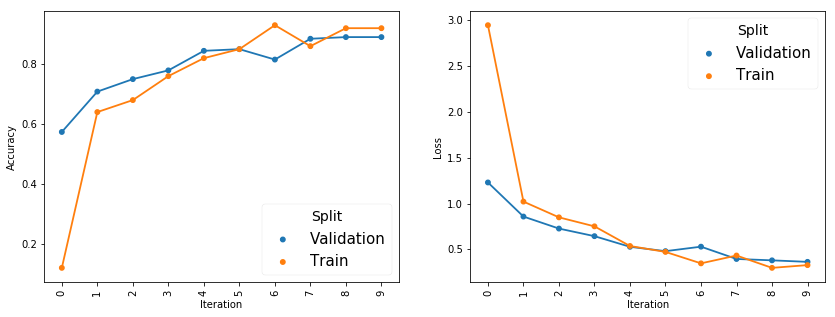

In [37]:
plot_loss_acc(train_loss, train_acc, val_loss, val_acc, CAL_STEP, num_iter)

## Apply Model to Test Dateset

In [38]:
acc, loss = network.evaluate(X_test, y_test)
print('Accuracy on test dataset is: ', "%.4f" %acc)

Accuracy on test dataset is:  0.9100


## Visualize Decision Boundary for Simple Example

In [39]:
# Only for synthetic example
# plot_decision_boundary(lambda x: network.predict(x), X, y)
# plt.title("Decision Boundary for hidden layer size 3")
# plt.show()

## Gradient check

The purpose is to confirm that gradient calculation was correct

In [ ]:
# Re-initialize network, with same X and y, fixed input, no weight update, no regularization
network.initialize(input = X, y = y, batch_size = batch_size)
a,b,c,d = network.train(num_iter = 10, learning_rate = 0., batch_size = batch_size, rand_ = False, lambda_ = 0.)

Perturbate X[0,0] by +/- 1e5

In [47]:
X_plus = X.copy()
X_plus[0,0] += 1e-5
X_minus = X.copy()
X_minus[0,0] -= 1e-5

Calculate gradient

In [ ]:
_, loss_plus = network.evaluate(X_plus, y)
_, loss_minus = network.evaluate(X_minus, y)
c_gradient = (loss_plus - loss_minus) / (2e-5) * X.shape[0]
print('Calculated Gradient: ', c_gradient)

In [ ]:
a_gradient = network.layers[0].dX[0,0]
print('Analytical Gradient: ' , a_gradient)

In [ ]:
print('Relative error: ', abs(c_gradient - a_gradient) / max(c_gradient, a_gradient))

A better implementation will be checking gradients also at following steps, and for all parameters